FileChooser(path='\\nas-emotional.fm.ul.pt\eMotional\Exp_4-outdoor_walk\lisbon\sourcedata\data\OE009', filenam…

Loading dataset: Lisbon_Lapa_sub-OE102009_2024-05-02T132016Z...
Reading 0 ... 583844  =      0.000 ...  1167.688 secs...
Attempting to automatically correct eeg timestamps to harp timestamps...
Done.
Dataset: <pluma.schema.Dataset object at 0x000001C36268DE90> loaded successfully, and sucessfully calibrated.


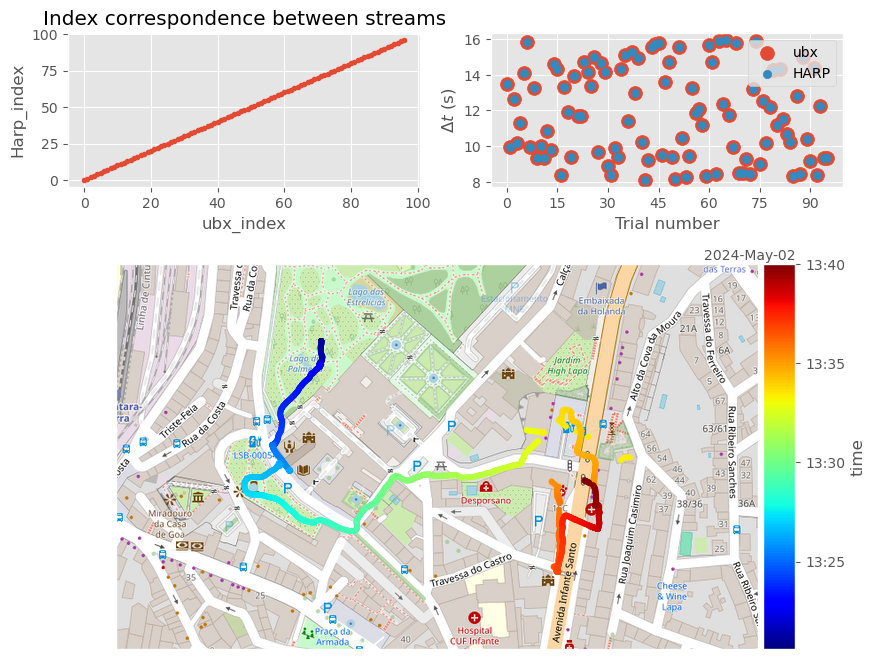

Failed Stream Harp stream from device 		TK, stream GPS_Latitude(227): Input dataframe is empty.
Failed Stream Harp stream from device 		TK, stream GPS_Longitude(228): Input dataframe is empty.
Failed Stream Harp stream from device 		TK, stream GPS_Altitude(229): Input dataframe is empty.
Failed Stream Harp stream from device 		TK, stream GPS_HasFix(232): Input dataframe is empty.


In [ ]:
# Import necessary modules
import os
import utils.for_setpath as path
import utils.for_empatica as empatica

# Data processing
import numpy as np
import matplotlib.pyplot as plt

# Pluma-python API  
from modules import *
from pluma.schema.outdoor import build_schema

# Load data
datapicker = create_datapicker(path=r'Z:\Exp_4-outdoor_walk\lisbon\sourcedata\data\OE009',schema=build_schema)
display(datapicker)

In [5]:
datapicker.dataset.streams.

AttributeError: 'Dataset' object has no attribute 'geodata'

# Export empatica to CSV

In [ ]:
import os
import utils.for_setpath as path
import utils.for_empatica as empatica

# Export data to csv
csv_outdir = os.path.join(path.sourcedata, 'supp', 'stress_csv', 'sub-OE009', 'ses-Lapa')
if not os.path.exists(csv_outdir): 
    os.makedirs(csv_outdir)
empatica.empatica_and_ecg_to_csv(datapicker, csv_outdir) 

# Export metrics as 1Hz data stream

In [ ]:
# Process Empatica data
input_directory = os.path.join(path.sourcedata, 'supp', 'stress_csv', 'sub-OE009', 'ses-Lapa')
output_directory = os.path.join(input_directory, '_1hz')
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

empatica.export_resampled_empatica_data(input_directory, output_directory)

# Correlations (Physiological and UTCI)

In [ ]:
# Import necessary modules
import pandas as pd
import numpy as np
import os
from scipy.stats import pearsonr, spearmanr, linregress
import matplotlib.pyplot as plt

# Set plotting parameters
plt.rcParams.update({'font.size': 12})

# Define paths and session information
session_name = 'Lapa' # Replace with your session name
subject_folder = 'sub-OE009' # Replace with your subject folder name
# Update these variables according to your directory structure
input_directory = os.path.join(path.sourcedata, 'supp', 'stress_csv', subject_folder, 'ses-'+session_name) 
output_dir = os.path.join(path.sourcedata, 'supp', 'correlation', subject_folder, 'ses-'+session_name)       
empatica_data_path = os.path.join(input_directory, '_1hz', 'data_all_1Hz.csv')
sourcedata_path = os.path.join(path.sourcedata, 'supp') # Replace with the path to 'sourcedata' directory

# Ensure output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load Empatica data
print("Loading Empatica data...")
empatica_data = pd.read_csv(empatica_data_path, parse_dates=['DateTime'])

# Ensure 'DateTime' is in datetime format
if empatica_data['DateTime'].dtype != 'datetime64[ns]':
    empatica_data['DateTime'] = pd.to_datetime(empatica_data['DateTime'], errors='coerce')

# Remove any rows with NaT in 'DateTime'
empatica_data = empatica_data.dropna(subset=['DateTime'])

# Floor to seconds to ensure alignment
empatica_data['DateTime'] = empatica_data['DateTime'].dt.floor('S')

# --- Climate Data Processing ---

# Locate the climate data CSV file
print("Locating climate data CSV file...")
log2_path = os.path.join(sourcedata_path, 'log2')
subject_path = os.path.join(log2_path, subject_folder)

# Find session folder containing the session name
session_folder = None
for folder in os.listdir(subject_path):
    if session_name in folder:
        session_folder = folder
        break

if session_folder is None:
    print(f"Session folder containing '{session_name}' not found in {subject_path}.")
else:
    session_path = os.path.join(subject_path, session_folder)

    # Find the CSV file containing 'geodata_processed' in the filename
    climate_csv_file = None
    for file in os.listdir(session_path):
        if 'geodata_processed' in file and file.endswith('.csv'):
            climate_csv_file = file
            break

    if climate_csv_file is None:
        print(f"No CSV file containing 'geodata_processed' found in {session_path}.")
    else:
        climate_csv_path = os.path.join(session_path, climate_csv_file)
        print(f"Climate data CSV file found: {climate_csv_path}")

        # Read the climate data CSV file
        print("Reading climate data...")
        climate_data = pd.read_csv(climate_csv_path)

        # Ensure datetime column is parsed correctly
        if 'DateTime' in climate_data.columns:
            climate_data['DateTime'] = pd.to_datetime(climate_data['DateTime'], errors='coerce')
        else:
            print("No 'DateTime' column found in climate data. Please ensure the CSV contains datetime information.")
            climate_data = None

        # Remove any rows with NaT in 'DateTime'
        if climate_data is not None:
            climate_data = climate_data.dropna(subset=['DateTime'])

        # Check if 'utci' column exists
        if climate_data is not None and 'utci' not in climate_data.columns:
            print("'utci' column not found in climate data.")
            climate_data = None

        if climate_data is not None:
            # Check if 'second' column exists
            if 'second' in climate_data.columns:
                # Combine 'DateTime' and 'second' to create a full datetime with seconds
                print("Combining 'DateTime' and 'second' to create full datetime with seconds...")
                # Floor 'DateTime' to the nearest minute
                climate_data['DateTime'] = climate_data['DateTime'].dt.floor('min')
                # Add 'second' column as timedelta
                climate_data['DateTime'] += pd.to_timedelta(climate_data['second'], unit='s')
                # Now 'DateTime' includes seconds
            else:
                print("'second' column not found in climate data.")
                climate_data = None

            # Ensure 'DateTime' is in datetime format
            if climate_data is not None and climate_data['DateTime'].dtype != 'datetime64[ns]':
                climate_data['DateTime'] = pd.to_datetime(climate_data['DateTime'], errors='coerce')
                climate_data = climate_data.dropna(subset=['DateTime'])

            # Check data type
            print("Climate data 'DateTime' dtype:", climate_data['DateTime'].dtype)

            # Proceed if 'DateTime' and 'utci' are available
            if climate_data is not None:
                # Merge Empatica data with climate data on 'DateTime'
                print("Merging Empatica data with climate data...")
                combined_data = pd.merge(empatica_data, climate_data[['DateTime', 'utci']], on='DateTime', how='inner')

                # Save the combined data to CSV with proper datetime formatting
                combined_data.to_csv(os.path.join(output_dir, 'combined_data.csv'), index=False, date_format='%Y-%m-%d %H:%M:%S')

                # Perform correlations between 'utci' and Empatica variables
                print("Performing correlations between 'utci' and Empatica variables...")
                empatica_vars = combined_data.select_dtypes(include=[np.number]).columns.drop('utci')
                correlation_results = []

                for var in empatica_vars:
                    # Drop NaN values for the pair
                    valid_data = combined_data[['utci', var]].dropna()
                    if len(valid_data) < 2:
                        print(f"Not enough data to compute correlation between 'utci' and '{var}'.")
                        continue

                    # Pearson correlation
                    pearson_corr, pearson_p = pearsonr(valid_data['utci'], valid_data[var])

                    # Spearman correlation
                    spearman_corr, spearman_p = spearmanr(valid_data['utci'], valid_data[var])

                    # Append results
                    correlation_results.append({
                        'Variable': var,
                        'Pearson_Correlation': pearson_corr,
                        'Pearson_p_value': pearson_p,
                        'Spearman_Correlation': spearman_corr,
                        'Spearman_p_value': spearman_p
                    })

                    # Plot scatter plot with best-fit line
                    plt.figure(figsize=(8, 6))

                    # Scatter plot
                    plt.scatter(valid_data['utci'], valid_data[var], color='blue', alpha=0.6, edgecolor='k', label='Data')

                    # Best-fit line using linear regression (OLS)
                    slope, intercept, r_value, p_value, std_err = linregress(valid_data['utci'], valid_data[var])
                    x_vals = np.array([valid_data['utci'].min(), valid_data['utci'].max()])
                    y_vals = intercept + slope * x_vals
                    plt.plot(x_vals, y_vals, color='red', linewidth=2, label='OLS Linear Regression')

                    # Aesthetics adjustments
                    plt.xlabel('Universal Thermal Climate Index (UTCI)', fontsize=14)
                    plt.ylabel(var, fontsize=14)
                    plt.title(f'Relationship between {var} and UTCI', fontsize=16)
                    plt.legend(frameon=False, fontsize=12)

                    # Remove background grid and frame
                    plt.gca().spines['top'].set_visible(False)
                    plt.gca().spines['right'].set_visible(False)
                    plt.gca().spines['left'].set_linewidth(1.5)
                    plt.gca().spines['bottom'].set_linewidth(1.5)

                    # Include Pearson and Spearman correlation coefficients and p-values in the plot
                    textstr = '\n'.join((
                        r'Pearson $r=%.2f$ (p=%.2e)' % (pearson_corr, pearson_p),
                        r'Spearman $\rho=%.2f$ (p=%.2e)' % (spearman_corr, spearman_p)
                    ))
                    # Place text box in upper left in axes coords
                    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
                            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

                    # Tight layout for better spacing
                    plt.tight_layout()

                    # Save the figure
                    plt.savefig(os.path.join(output_dir, f'scatter_{var}_vs_utci.png'), dpi=300)
                    plt.close()

                # Save correlation results to CSV
                print("Saving correlation results...")
                correlation_df = pd.DataFrame(correlation_results)
                correlation_df.to_csv(os.path.join(output_dir, 'correlation_results.csv'), index=False)

                print("Correlation analysis complete. Results saved to the output directory.")
            else:
                print("Climate data could not be processed due to missing 'DateTime', 'utci', or 'second' column.")


# Covariance Matrices
Perform correlations for:
- within subjects
- within paths
- between paths
- between subjects

In [ ]:
import pandas as pd
import numpy as np
import os
from scipy.stats import pearsonr, spearmanr, linregress
import matplotlib.pyplot as plt

def compute_covariance_matrix(data, method='pairwise'):
    """
    Compute covariance matrix using different methods to handle missing data.

    Args:
        data (pd.DataFrame): DataFrame with numeric variables.
        method (str): Method to handle missing values. Options are:
            - 'pairwise': Computes pairwise covariances, ignoring missing values.
            - 'mean_impute': Fills missing values with the column mean.
            - 'median_impute': Fills missing values with the column median.
            - 'interpolate': Uses linear interpolation to fill missing values.

    Returns:
        pd.DataFrame: Covariance matrix.
    """
    if method == 'pairwise':
        # Pandas computes pairwise covariances by default
        return data.cov()
    elif method == 'mean_impute':
        filled_data = data.fillna(data.mean())
    elif method == 'median_impute':
        filled_data = data.fillna(data.median())
    elif method == 'interpolate':
        filled_data = data.interpolate(method='linear', limit_direction='both')
    else:
        raise ValueError(f"Unknown method: {method}")
    return filled_data.cov()

def process_data(empatica_data_path, climate_data_path, output_dir):
    
    # Load Empatica data
    empatica_data = pd.read_csv(empatica_data_path, parse_dates=['DateTime'])
    empatica_data['DateTime'] = pd.to_datetime(empatica_data['DateTime'], errors='coerce')
    empatica_data = empatica_data.dropna(subset=['DateTime']).set_index('DateTime')

    # Load Climate data
    climate_data = pd.read_excel(climate_data_path, parse_dates=['time'])
    climate_data['time'] = pd.to_datetime(climate_data['time'], errors='coerce')
    climate_data = climate_data.dropna(subset=['time']).set_index('time')

    # Merge data
    combined_data = pd.merge(empatica_data, climate_data[['utci']], left_index=True, right_index=True, how='inner')
    combined_data.to_csv(os.path.join(output_dir, 'combined_data.csv'))

    # Select numeric columns for covariance analysis
    numeric_data = combined_data.select_dtypes(include=[np.number])

    # Compute covariance matrices with different methods
    covariance_methods = ['pairwise', 'mean_impute', 'median_impute', 'interpolate']
    for method in covariance_methods:
        print(f"Computing covariance matrix using {method} method...")
        covariance_matrix = compute_covariance_matrix(numeric_data, method=method)
        covariance_matrix.to_csv(os.path.join(output_dir, f'covariance_matrix_{method}.csv'))
        print(f"Covariance matrix ({method}) saved.")

    print("Covariance matrix computations complete.")

def main():
    # Define paths
    session_name = 'Lapa'
    subject_folder = 'sub-OE009'
    output_dir = os.path.join(path.sourcedata, 'supp', 'correlation', subject_folder, f'ses-{session_name}')
    empatica_data_path = os.path.join(path.sourcedata, 'supp', 'stress_csv', subject_folder, f'ses-{session_name}', '_1hz', 'data_all_1Hz.csv')
    climate_data_path = os.path.join(path.sourcedata, 'supp', 'geodata','log', subject_folder, f'ses-{session_name}', f'{subject_folder}_ses-{session_name}_geodata.xlsx')

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Process data and compute covariance matrices
    process_data(empatica_data_path, climate_data_path, output_dir)

if __name__ == "__main__":
    main()


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, ttest_rel, pearsonr, spearmanr

###############################################################################
# Choose which columns from geodata to include (besides "time") 
# Typically, you want numeric columns that might be correlated with physiological data.
# Exclude obviously irrelevant columns like 'geometry' or duplicates.
###############################################################################
SELECTED_GEODATA_COLS = [
    # Potential environment/climate columns
    "tk_airquality_iaqindex_value","tk_airquality_temperature_value","tk_airquality_humidity_value",
    "tk_airquality_airpressure_value","tk_soundpressurelevel_spl_value","tk_humidity_humidity_value",
    "tk_analogin_voltage_value","tk_particulatematter_pm1_0_value","tk_particulatematter_pm2_5_value",
    "tk_particulatematter_pm10_0_value","tk_dual0_20ma_solarlight_value","tk_thermocouple_temperature_value",
    "tk_ptc_airtemp_value","atmos_northwind_value","atmos_eastwind_value","atmos_gustwind_value",
    "atmos_airtemperature_value","accelerometer_orientation_x","accelerometer_orientation_y","accelerometer_orientation_z",
    "accelerometer_gyroscope_x","accelerometer_gyroscope_y","accelerometer_gyroscope_z","accelerometer_linearaccl_x",
    "accelerometer_linearaccl_y","accelerometer_linearaccl_z","accelerometer_magnetometer_x","accelerometer_magnetometer_y",
    "accelerometer_magnetometer_z","accelerometer_accl_x","accelerometer_accl_y","accelerometer_accl_z",
    "accelerometer_gravity_x","accelerometer_gravity_y","accelerometer_gravity_z",
    # Merged columns from subsequent steps
    "empatica_e4_gsr","empatica_e4_hr","empatica_e4_ibi","empatica_e4_temperature",
    "humidity","wind_speed","temp_atmos","temp_tk","temp_tk_ptc","temp_radiant","utci",
    "day_of_year","ghi","hPa","dew_point","solar_altitude","solar_azimuth","mrt"
]

###############################################################################
def compute_covariance_matrix(data, method='pairwise'):
    """
    Compute covariance matrix using different methods to handle missing data.
    """
    if method == 'pairwise':
        # Pandas defaults to pairwise complete for .cov()
        return data.cov()
    elif method == 'mean_impute':
        filled_data = data.fillna(data.mean(numeric_only=True))
    elif method == 'median_impute':
        filled_data = data.fillna(data.median(numeric_only=True))
    elif method == 'interpolate':
        filled_data = data.interpolate(method='linear', limit_direction='both')
    else:
        raise ValueError(f"Unknown method: {method}")
    return filled_data.cov()

def compute_correlation_matrix(data, method='pearson'):
    """
    Compute correlation matrix: 'pearson', 'spearman', or 'kendall'.
    """
    return data.corr(method=method)

def plot_heatmap(matrix, title, output_path):
    """
    Plots a heatmap of the given matrix (DataFrame).
    """
    plt.figure(figsize=(12,10))
    sns.heatmap(matrix, annot=False, cmap='coolwarm', square=True)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(output_path, dpi=150)
    plt.close()

def process_data(empatica_data_path, climate_data_path, output_dir):
    
    ###############################################################################
    # Load Empatica Data
    ###############################################################################
    empatica_data = pd.read_csv(empatica_data_path, parse_dates=['DateTime'])
    empatica_data['DateTime'] = pd.to_datetime(empatica_data['DateTime'], errors='coerce')
    empatica_data.dropna(subset=['DateTime'], inplace=True)
    empatica_data.set_index('DateTime', inplace=True)

    ###############################################################################
    # Load "geodata" / climate data
    ###############################################################################
    climate_data = pd.read_excel(climate_data_path, parse_dates=['time'])
    climate_data['time'] = pd.to_datetime(climate_data['time'], errors='coerce')
    climate_data.dropna(subset=['time'], inplace=True)
    climate_data.set_index('time', inplace=True)

    ###############################################################################
    # Merge
    # We'll gather columns from climate_data that we want 
    # (some may not exist, so we will safely drop missing)
    ###############################################################################
    available_cols = [c for c in SELECTED_GEODATA_COLS if c in climate_data.columns]
    # If none found, we proceed with a minimal set
    if not available_cols:
        print("No selected columns found in climate_data. Falling back to just utci if present.")
        if "utci" in climate_data.columns:
            available_cols = ["utci"]
        else:
            print("No utci in climate data; the merge will produce minimal columns.")
            available_cols = climate_data.columns  # fallback to all

    # Subset climate_data
    climate_subset = climate_data[available_cols]

    # Merge
    combined_data = pd.merge(empatica_data, climate_subset, 
                             left_index=True, right_index=True, how='inner')

    # Export the final table
    combined_data.to_csv(os.path.join(output_dir, 'combined_data_full.csv'))
    print(f"Exported final combined data with {len(combined_data)} rows, {combined_data.shape[1]} columns.")

    ###############################################################################
    # Covariance / Correlation
    ###############################################################################
    # We'll select numeric columns only
    numeric_data = combined_data.select_dtypes(include=[np.number]).copy()

    # Possibly we drop columns that have zero variance or near-constant
    # or too many NaNs, but let's keep it simple

    # 1) Covariance with different methods
    covariance_methods = ['pairwise', 'mean_impute', 'median_impute', 'interpolate']
    for method in covariance_methods:
        cov_mat = compute_covariance_matrix(numeric_data, method=method)
        cov_mat.to_csv(os.path.join(output_dir, f'cov_matrix_{method}.csv'))
        plot_heatmap(cov_mat, f"Covariance Matrix [{method}]", 
                     os.path.join(output_dir, f'cov_matrix_{method}.png'))

    # 2) Correlation (Pearson, Spearman)
    for corr_method in ['pearson','spearman']:
        corr_mat = compute_correlation_matrix(numeric_data, method=corr_method)
        corr_mat.to_csv(os.path.join(output_dir, f'corr_matrix_{corr_method}.csv'))
        plot_heatmap(corr_mat, f"Correlation Matrix [{corr_method}]", 
                     os.path.join(output_dir, f'corr_matrix_{corr_method}.png'))

    print("Covariance and correlation matrices saved & plotted.")

def main():
    # Define paths
    session_name = 'Lapa'
    subject_folder = 'sub-OE009'
    output_dir = os.path.join(path.sourcedata, 'supp', 'correlation', subject_folder, f'ses-{session_name}')
    empatica_data_path = os.path.join(path.sourcedata, 'supp', 'stress_csv', subject_folder, f'ses-{session_name}', '_1hz', 'data_all_1Hz.csv')
    climate_data_path = os.path.join(path.sourcedata, 'supp', 'geodata','log', subject_folder, f'ses-{session_name}', f'{subject_folder}_ses-{session_name}_geodata.xlsx')
    os.makedirs(output_dir, exist_ok=True)

    process_data(empatica_data_path, climate_data_path, output_dir)

if __name__ == "__main__":
    main()


# Batch Processing

In [ ]:
from modules import *
from utils import *
%matplotlib widget

# MAIN SCRIPT
for participant_folder in os.listdir(sourcedata):
    if participant_folder.startswith("OE"):
        participant_path = os.path.join(sourcedata, participant_folder)
        for session_folder in os.listdir(participant_path):
            session_path = os.path.join(participant_path, session_folder)
            if os.path.isdir(session_path):
                process_session(session_path, participant_folder, session_folder)

# Tests - Fixing ecg error (speak with NGR)

In [ ]:
# Utils
import os
import utils.for_setpath as path

# For empatica
import pandas as pd
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import biosppy
import os
import datetime

def process_empatica_data(input_dir, output_dir):
    """
    Processes EDA and related physiological data from CSV files,
    resamples to 1Hz, and saves the combined data to a CSV file.
    All generated figures are saved to the output directory.

    Parameters:
    - input_dir: Directory containing the input CSV files.
    - output_dir: Directory where the output CSV and figures will be saved.

    Output:
    - Saves 'data_all_1Hz.csv' to the output directory.
    - Saves all generated figures to the output directory.
    """

    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Set default plotting parameters
    plt.rcParams['agg.path.chunksize'] = 10000
    plt.rcParams.update({'font.size': 18})

    # Sampling frequencies
    fs_bvp = 64
    fs_eda = 4

    # Load data from CSV files
    print("Loading data...")
    ecg_hr = pd.read_csv(os.path.join(input_dir, 'ecg_hr.csv'))
    ecg_signal = pd.read_csv(os.path.join(input_dir, 'ecg.csv'))
    bvp_subj = pd.read_csv(os.path.join(input_dir, 'e4_bvp.csv'))
    ibi_subj = pd.read_csv(os.path.join(input_dir, 'e4_ibi.csv'))
    eda_subj = pd.read_csv(os.path.join(input_dir, 'e4_gsr.csv'))
    hr_subj = pd.read_csv(os.path.join(input_dir, 'e4_hr.csv'))
    acc_subj = pd.read_csv(os.path.join(input_dir, 'e4_acc.csv'))
    temp_subj = pd.read_csv(os.path.join(input_dir, 'e4_temp.csv'))

    # Process datetime columns
    print("Processing datetime columns...")
    ecg_hr['DateTime'] = pd.to_datetime(ecg_hr['Seconds'].str[:-3], format="%Y-%m-%d %H:%M:%S.%f")
    ecg_signal['DateTime'] = pd.to_datetime(ecg_signal['Seconds'].str[:-3], format="%Y-%m-%d %H:%M:%S.%f")
    eda_subj['DateTime'] = pd.to_datetime(eda_subj['E4_Seconds'].str[:-3], format="%Y-%m-%d %H:%M:%S.%f")
    bvp_subj['DateTime'] = pd.to_datetime(bvp_subj['E4_Seconds'].str[:-3], format="%Y-%m-%d %H:%M:%S.%f")
    ibi_subj['DateTime'] = pd.to_datetime(ibi_subj['E4_Seconds'].str[:-3], format="%Y-%m-%d %H:%M:%S.%f")
    hr_subj['DateTime'] = pd.to_datetime(hr_subj['E4_Seconds'].str[:-3], format="%Y-%m-%d %H:%M:%S.%f")
    acc_subj['DateTime'] = pd.to_datetime(acc_subj['E4_Seconds'].str[:-3], format="%Y-%m-%d %H:%M:%S.%f")
    temp_subj['DateTime'] = pd.to_datetime(temp_subj['E4_Seconds'].str[:-3], format="%Y-%m-%d %H:%M:%S.%f")

    # Rename columns for consistency
    eda_subj.rename(columns={'Value': 'Values'}, inplace=True)
    bvp_subj.rename(columns={'Value': 'Values'}, inplace=True)
    ibi_subj.rename(columns={'Value': 'Values'}, inplace=True)
    hr_subj.rename(columns={'Value': 'Values'}, inplace=True)
    acc_subj.rename(columns={'Value': 'Values'}, inplace=True)
    temp_subj.rename(columns={'Value': 'Values'}, inplace=True)

    # Compute accelerometer magnitude
    acc_subj['Magnitude'] = np.sqrt(acc_subj['AccX']**2 + acc_subj['AccY']**2 + acc_subj['AccZ']**2)

    # Filter EDA signal
    print("Filtering EDA signal...")
    eda_subj['Filtered'] = scipy.signal.savgol_filter(eda_subj['Values'], window_length=11, polyorder=5)
    b, a = scipy.signal.butter(5, 0.05, btype='highpass', fs=fs_eda)
    eda_subj['NEW_EDA'] = scipy.signal.filtfilt(b, a, eda_subj['Filtered'])

    # Plot EDA signals
    print("Plotting EDA signals...")
    plt.figure(figsize=(15, 7))
    plt.plot(eda_subj['DateTime'], eda_subj['Values'], label='Raw EDA')
    plt.plot(eda_subj['DateTime'], eda_subj['Filtered'], label='Filtered EDA')
    plt.plot(eda_subj['DateTime'], eda_subj['NEW_EDA'], label='High-pass Filtered EDA')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('EDA Value')
    plt.title('EDA Signal Processing')
    plt.savefig(os.path.join(output_dir, 'eda_signals.png'), dpi=300)
    plt.close()

    # Process IBI data
    print("Processing IBI data...")
    ibi_subj['IBI'] = ibi_subj['Values']
    ibi_subj['bpm'] = 60 / ibi_subj['IBI']

    # Process ECG HR data
    ecg_hr['HeartRate'] = ecg_hr['HeartRate']

    # Plot HR signals
    print("Plotting HR signals...")
    plt.figure(figsize=(15, 7))
    plt.plot(ecg_hr['DateTime'], ecg_hr['HeartRate'], label='ECG Heart Rate')
    plt.plot(ibi_subj['DateTime'], ibi_subj['bpm'], label='E4 IBI Heart Rate')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Heart Rate (bpm)')
    plt.title('Heart Rate Comparison')
    plt.savefig(os.path.join(output_dir, 'hr_signals.png'), dpi=300)
    plt.close()

    # Resample data to 1Hz
    print("Resampling data to 1Hz...")
    data_ecg_hr = ecg_hr.set_index('DateTime').resample("1S").mean().reset_index()
    data_ibi = ibi_subj.set_index('DateTime').resample("1S").mean().reset_index()
    data_temp = temp_subj.set_index('DateTime').resample("1S").mean().reset_index()
    data_eda = eda_subj.set_index('DateTime').resample("1S").mean().reset_index()
    data_acc = acc_subj.set_index('DateTime').resample("1S").mean().reset_index()
    data_bvp = bvp_subj.set_index('DateTime').resample("1S").mean().reset_index()

    # Merge all data into a single DataFrame
    print("Merging data...")
    data_all = data_ecg_hr[['DateTime', 'HeartRate']].rename(columns={'HeartRate': 'ECG_HR_NGRs'})
    data_all = pd.merge(data_all, data_ibi[['DateTime', 'bpm']].rename(columns={'bpm': 'E4_HR_IBI'}), on='DateTime', how='left')
    data_all = pd.merge(data_all, data_temp[['DateTime', 'Values']].rename(columns={'Values': 'TEMP'}), on='DateTime', how='left')
    data_all = pd.merge(data_all, data_eda[['DateTime', 'Values', 'NEW_EDA']].rename(columns={'Values': 'EDA_RAW', 'NEW_EDA': 'EDA_PHASIC'}), on='DateTime', how='left')
    data_all = pd.merge(data_all, data_acc[['DateTime', 'AccX', 'AccY', 'AccZ']], on='DateTime', how='left')
    data_all = pd.merge(data_all, data_bvp[['DateTime', 'Values']].rename(columns={'Values': 'BVP_Values'}), on='DateTime', how='left')

    # Plot merged data
    print("Plotting merged data...")
    plt.figure(figsize=(15, 7))
    plt.plot(data_all['DateTime'], data_all['ECG_HR_NGRs'], label='ECG HR NGRs')
    plt.plot(data_all['DateTime'], data_all['E4_HR_IBI'], label='E4 HR IBI')
    plt.plot(data_all['DateTime'], data_all['EDA_RAW'], label='EDA Raw')
    plt.plot(data_all['DateTime'], data_all['TEMP'], label='Temperature')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Merged Physiological Data')
    plt.savefig(os.path.join(output_dir, 'merged_data.png'), dpi=300)
    plt.close()

    # Save combined data to CSV
    print("Saving combined data to CSV...")
    data_all.to_csv(os.path.join(output_dir, 'data_all_1Hz.csv'), index=False)

    print("Processing complete. All figures and CSV file saved to the output directory.")


# Process Empatica data
input_directory = os.path.join(path.sourcedata, 'supp', 'stress_csv', 'sub-OE009', 'ses-Lapa')
output_directory = os.path.join(input_directory, '_1hz')
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

process_empatica_data(input_directory, output_directory)
